In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.display import HTML

import os
import itertools
import gc
import pickle
import random

import numpy as np
import pandas as pd
import pandas_summary as pds
import seaborn as sns
import xgboost as xgb

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler, Normalizer, MinMaxScaler
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import keras
from keras import initializers
from keras.layers import Input, Embedding, Dense, Flatten, Dropout
from keras.models import Model
from keras.layers.merge import concatenate, multiply
from keras.layers.advanced_activations import LeakyReLU


from zillow import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
zillow_data = DataLoader()
gc.collect()

0

In [25]:
subm = pd.read_csv('zillow/submission.csv.gz')
txn = zillow_data.preprocessed.transactions().set_index('parcelid')
display(txn.loc[txn.transaction_month == 10, ('logerror')][:10])
subm = subm.set_index('ParcelId')
display(subm.loc[12681411])
subm['201610'].update(txn.loc[txn.transaction_month == 10, ('logerror')])
display(subm.loc[12681411])
display(subm.isnull().any())

parcelid
13927813    0.1249
12032773    0.0208
12921348    0.0178
17290242    0.0188
14530899    0.0020
13991964    0.2319
13037293   -0.0070
14444102   -0.0812
12448490    0.0944
11526663    0.0908
Name: logerror, dtype: float64

201610    0.0206
201611    0.0197
201612    0.0192
201710    0.0195
201711    0.0195
201712    0.0196
Name: 12681411, dtype: float64

201610    0.0227
201611    0.0197
201612    0.0192
201710    0.0195
201711    0.0195
201712    0.0196
Name: 12681411, dtype: float64

201610    False
201611    False
201612    False
201710    False
201711    False
201712    False
dtype: bool

In [28]:
subm = pd.read_csv('zillow/submission.csv.gz')

def patch(subm):
    txn = zillow_data.preprocessed.transactions().set_index('parcelid')
    subm = subm.set_index('ParcelId')
    months = [10, 11, 12]
    dates = ['201610', '201611', '201612']
    for month, date in zip(months, dates):
        subm[date].update(txn.loc[txn.transaction_month == month, ('logerror')])
    return subm

patch(subm).to_csv('zillow/submission.patched.csv.gz', index=True, float_format='%.4f', compression='gzip')

In [137]:
vals = describe_values(zillow_data.properties())
cols_high_missing = set(vals.loc[vals['missing %'] > 90]['column'])
display(vals)
cols_high_missing

,column,dtype,sample,unique len,missing %
57,parcelid,int64,"[10754147, 10759547, 10843547]",2985217,0.000000
56,airconditioningtypeid,float64,"[1.0, 3.0, 5.0]",8,72.815410
55,architecturalstyletypeid,float64,"[2.0, 3.0, 5.0]",9,99.796966
54,basementsqft,float64,"[20.0, 24.0, 25.0]",752,99.945465
53,bathroomcnt,float64,"[0.0, 0.5, 1.0]",38,0.383959
52,bedroomcnt,float64,"[0.0, 1.0, 2.0]",22,0.383557
51,buildingclasstypeid,float64,"[1.0, 2.0, 3.0]",6,99.576949
50,buildingqualitytypeid,float64,"[1.0, 2.0, 3.0]",13,35.063749
49,calculatedbathnbr,float64,"[1.0, 1.5, 2.0]",35,4.318346
48,decktypeid,float64,"[66.0, nan]",2,99.427311


{'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplaceflag',
 'hashottuborspa',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'storytypeid',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26'}

# Training & Testing w/ XGBoost

In [38]:
def remove_outliers(X, y):
    f = np.abs(y-y.mean())<=(3*y.std())
    return X[f], y[f]

def train_test_split(X, y, month=9):
    c = X.transaction_month
    return X[c < month], X[c == month], X[c > month], y[c < month], y[c == month], y[c > month]


def adapt_for_xgb(df, dropcols=set()):
    mustdropcols = set([
                'propertyzoningdesc', 
                'propertycountylandusecode', 
                'censustractandblock', 
                'rawcensustractandblock',
                'parcelid',
               ])
    
    mustdropcols = mustdropcols | set(dropcols)
    df = df.drop(mustdropcols, axis=1)
    
    for c in df.columns:
        if df[c].dtype.name == 'object':
            df[c] = df[c].replace('',0).astype(np.float32)
    
    return df

def xgb_train(params=None, dropcols=set()):
    train = zillow_data.preprocessed.training()
    train = adapt_for_xgb(train, dropcols)
    
    X = train.drop(['logerror', 'logerror_abs'], axis=1)
    y = train['logerror']
    
    del train; gc.collect()
    
    x_train, x_valid, x_test, y_train, y_valid, y_test = train_test_split(X, y)
#     x_train, y_train = remove_outliers(x_train, y_train)

    d_train = xgb.DMatrix(x_train, label=y_train, silent=True)
    d_valid = xgb.DMatrix(x_valid, label=y_valid, silent=True)
    d_test = xgb.DMatrix(x_test, label=y_test, silent=True)
    
    del x_train, x_valid, x_test; gc.collect()

    if not params:
        params = {
            'eta': 0.005,
            'objective': 'reg:linear',
            'eval_metric': 'mae',
            'max_depth': 3,
            'silent': 1,
            'subsample': 0.3,
            'colsample_bytree': 0.1,
            'min_child_weight': 4,
            'lambda': 2,
        }

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=False)
    mae = mean_absolute_error(y_test, clf.predict(d_test))

    vmae = float(clf.attr('best_score'))
    amae = (d_valid.num_row() * vmae) + (d_test.num_row() * mae)
    amae = amae / (d_valid.num_row() + d_test.num_row())

    print ("Valid MAE: {}, Test MAE: {}, Total MAE: {}".format(vmae, mae, amae))
    print ("\n")
    
    del d_train, d_valid, d_test; gc.collect()
    
    return clf, mae, amae


def xgb_predict(clf, dropcols=set()):
    # build the test set
    subm = pd.DataFrame()
    subm['ParcelId'] = zillow_data.preprocessed.properties()['parcelid']
    months = [10, 11, 12, 22, 23, 24]
    dates = ['201610', '201611', '201612', '201710', '201711', '201712']
#     months = [10]
#     dates = ['201610']
    for month, date in zip(months, dates):
        print('Predicting...', date)

        merged = zillow_data.preprocessed.prediction(month)
        merged = adapt_for_xgb(merged, dropcols)
        gc.collect()
        
        dm_test = xgb.DMatrix(merged)
        del merged; gc.collect()
        
        subm[date] = clf.predict(dm_test)
        del dm_test; gc.collect()
    
    subm.to_csv('zillow/submission.csv.gz', index=False, float_format='%.4f', compression='gzip')
    return subm

    
def xgb_importance(clf):
    importance = clf.get_fscore()
    importance = sorted(importance.items(), key=lambda x: x[1])

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    return df
    
# train a model
def train_predict(params=None, predict=False, plot_imp=False, dropcols=set()):
    clf, mae, _ = xgb_train(params, dropcols)
    subm = None
    if predict:
        subm = xgb_predict(clf, dropcols)
    imp = None
    if plot_imp:
        imp = xgb_importance(clf)
    return clf, subm, imp

In [51]:
zillow_data = DataLoader()
gc.collect()

24

Valid MAE: 0.066136, Test MAE: 0.06539425155784899, Total MAE: 0.06578627238544717


                         feature    fscore
0                     decktypeid  0.000432
1                    storytypeid  0.000719
2                 regionidcounty  0.000719
3                   pooltypeid10  0.001151
4                           fips  0.001295
5                    poolsizesum  0.001439
6          airconditioningtypeid  0.001870
7                    pooltypeid2  0.002014
8                numberofstories  0.002302
9                 hashottuborspa  0.002590
10                  fireplacecnt  0.002733
11                  basementsqft  0.002877
12          finishedsquarefeet13  0.003165
13            yardbuildingsqft17  0.003740
14            yardbuildingsqft26  0.003740
15        logerror_abs_month_var  0.004028
16                   pooltypeid7  0.005035
17            logerror_month_std  0.005179
18           threequarterbathnbr  0.005755
19         buildingqualitytypeid  0.005898
20          

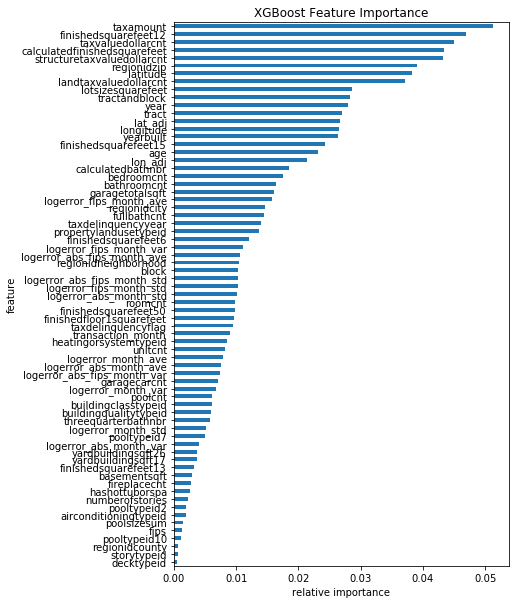

In [39]:
clf, subm, imp = train_predict(params=None, predict=False, plot_imp=True)

In [32]:
print (list(imp.feature))

['decktypeid', 'storytypeid', 'regionidcounty', 'pooltypeid10', 'fips', 'poolsizesum', 'airconditioningtypeid', 'pooltypeid2', 'numberofstories', 'hashottuborspa', 'fireplacecnt', 'basementsqft', 'finishedsquarefeet13', 'yardbuildingsqft17', 'yardbuildingsqft26', 'logerror_abs_month_var', 'pooltypeid7', 'logerror_month_std', 'threequarterbathnbr', 'buildingqualitytypeid', 'buildingclasstypeid', 'poolcnt', 'logerror_month_var', 'garagecarcnt', 'logerror_abs_fips_month_var', 'logerror_abs_month_ave', 'logerror_month_ave', 'unitcnt', 'heatingorsystemtypeid', 'transaction_month', 'taxdelinquencyflag', 'finishedfloor1squarefeet', 'finishedsquarefeet50', 'roomcnt', 'logerror_abs_month_std', 'logerror_fips_month_std', 'logerror_abs_fips_month_std', 'block', 'regionidneighborhood', 'logerror_abs_fips_month_ave', 'logerror_fips_month_var', 'finishedsquarefeet6', 'propertylandusetypeid', 'taxdelinquencyyear', 'fullbathcnt', 'regionidcity', 'logerror_fips_month_ave', 'garagetotalsqft', 'bathroomc

In [34]:
print (zillow_data.preprocessed.properties().columns)

/home/terence/Projects/dl_projects/zillow.py:60: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  self.preprocess_properties()


Index(['rawcensustractandblock', 'fips', 'tract', 'block', 'tractandblock',
       'yearbuilt', 'year', 'age', 'hashottuborspa', 'taxdelinquencyflag',
       'propertycountylandusecode', 'propertyzoningdesc', 'longitude',
       'lon_adj', 'latitude', 'lat_adj', 'distance', 'lon_fips_mean',
       'lat_fips_mean', 'lon_adj_fips', 'lat_adj_fips', 'distance_fips',
       'parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylanduse

In [22]:
zdata = zillow_data.preprocessed
props = zdata.properties()
loc_fips_mean = props[['longitude', 'latitude', 'fips']].groupby(['fips']).mean().reset_index()
loc_fips_mean.columns = ['fips', 'lon_fips_mean', 'lat_fips_mean']
loc_fips_mean

,fips,lon_fips_mean,lat_fips_mean
0,,0.000000e+00,0.000000e+00
1,6037,-1.182449e+08,3.407911e+07
2,6059,-1.178438e+08,3.371827e+07
3,6111,-1.190066e+08,3.424374e+07


In [53]:
zdata = zillow_data.preprocessed
zdata.properties().isnull().any().any()

False

# Baseline MAE = 0.0653808454738

In [40]:
def recursive_feature_selection(cols, dropcols=None, reverse=False):
    if dropcols == None:
        dropcols = from_pickle('zillow/dropcols.pkl')
    if dropcols == None:
        dropcols = set()
    cols = set(zillow_data.preprocessed.properties().columns)
    cols = cols - dropcols
    _, _, mae = xgb_train(dropcols=dropcols)
    mae_best = mae
    mae_best_pass = mae

    i = 0
    while True:
        i += 1
        print ('Pass: ', i)
        for c in cols:
            print ('Evaluating: ', c)
            if reverse:
                clf, _, mae = xgb_train(dropcols=dropcols - set([c]))
            else:
                clf, _, mae = xgb_train(dropcols=dropcols | set([c]))
    #         mae = float(clf.attr('best_score'))
            if mae < mae_best_pass:
                mae_best_pass = mae
                dropc = c
        if mae_best_pass >= mae_best:
            print ('No more improvements')
            break
        else:
            print ('Dropping: ', dropc)
            print ('Best MAE: ', mae_best_pass)
            if reverse:
                cols.add(dropc)
                dropcols.remove(dropc)
            else:
                cols.remove(dropc)
                dropcols.add(dropc)
            to_pickle(dropcols, 'zillow/dropcols.pkl')
            mae_best = mae_best_pass
    print (dropcols)
    

In [41]:
cols = set(zillow_data.preprocessed.properties().columns)
recursive_feature_selection(cols, None)

Valid MAE: 0.066136, Test MAE: 0.06539425155784899, Total MAE: 0.06578627238544717


Pass:  1
Evaluating:  basementsqft
Valid MAE: 0.066156, Test MAE: 0.06539411577050232, Total MAE: 0.06579677854565497


Evaluating:  architecturalstyletypeid
Valid MAE: 0.066164, Test MAE: 0.06540791277547152, Total MAE: 0.06580751178054191


Evaluating:  propertyzoningdesc
Valid MAE: 0.066136, Test MAE: 0.06539425155784899, Total MAE: 0.06578627238544717


Evaluating:  heatingorsystemtypeid
Valid MAE: 0.066189, Test MAE: 0.06540318102032204, Total MAE: 0.06581849352959049


Evaluating:  garagetotalsqft
Valid MAE: 0.066168, Test MAE: 0.0654016695637358, Total MAE: 0.06580668219978095


Evaluating:  yardbuildingsqft26
Valid MAE: 0.066149, Test MAE: 0.06542623081522674, Total MAE: 0.06580822093192398


Evaluating:  taxamount
Valid MAE: 0.06621, Test MAE: 0.06548662832177961, Total MAE: 0.06586893686176748


Evaluating:  finishedsquarefeet6
Valid MAE: 0.066179, Test MAE: 0.06540606522054923, Total MAE: 0.

Valid MAE: 0.066109, Test MAE: 0.06536190219573577, Total MAE: 0.06575675021007756


Evaluating:  architecturalstyletypeid
Valid MAE: 0.066108, Test MAE: 0.06536654301883744, Total MAE: 0.06575840980664069


Evaluating:  propertyzoningdesc
Valid MAE: 0.066107, Test MAE: 0.06533723073511429, Total MAE: 0.06574406082349982


Evaluating:  heatingorsystemtypeid
Valid MAE: 0.066113, Test MAE: 0.06534300376424408, Total MAE: 0.06574995380880792


Evaluating:  garagetotalsqft
Valid MAE: 0.066109, Test MAE: 0.06535237751505017, Total MAE: 0.0657522594101429


Evaluating:  yardbuildingsqft26
Valid MAE: 0.066085, Test MAE: 0.06535172602649707, Total MAE: 0.06573926801999988


Evaluating:  taxamount
Valid MAE: 0.066155, Test MAE: 0.06543584894023101, Total MAE: 0.06581592684481169


Evaluating:  finishedsquarefeet6
Valid MAE: 0.066115, Test MAE: 0.06535010319639219, Total MAE: 0.06575435814448209


Evaluating:  finishedfloor1squarefeet
Valid MAE: 0.066103, Test MAE: 0.06535292534422914, Total MAE

Valid MAE: 0.06607, Test MAE: 0.06534128851695184, Total MAE: 0.06572641919257066


Evaluating:  heatingorsystemtypeid
Valid MAE: 0.066124, Test MAE: 0.06536647365021778, Total MAE: 0.06576683324613126


Evaluating:  garagetotalsqft
Valid MAE: 0.066088, Test MAE: 0.06536379331706196, Total MAE: 0.06574654316467093


Evaluating:  yardbuildingsqft26
Valid MAE: 0.066113, Test MAE: 0.06538684279316344, Total MAE: 0.06577062351047096


Evaluating:  taxamount
Valid MAE: 0.066162, Test MAE: 0.06548921722142709, Total MAE: 0.0658447890658183


Evaluating:  finishedsquarefeet6
Valid MAE: 0.066102, Test MAE: 0.06537810546211939, Total MAE: 0.06576069033821405


Evaluating:  finishedfloor1squarefeet
Valid MAE: 0.066083, Test MAE: 0.06535773499614879, Total MAE: 0.0657410441760282


Evaluating:  unitcnt
Valid MAE: 0.066119, Test MAE: 0.06538903770195577, Total MAE: 0.06577482944472629


Evaluating:  calculatedbathnbr
Valid MAE: 0.066086, Test MAE: 0.06536325296024839, Total MAE: 0.0657452313730993

In [ ]:
dropcols = ['fips', 'tractandblock', 'roomcnt', 'bedroomcnt', 'taxdelinquencyflag']
train_predict(params=None, predict=True, plot_imp=True, dropcols=dropcols)

In [ ]:
dropcols = ['roomcnt', 'bedroomcnt', 'taxdelinquencyflag']
train_predict(params=None, predict=True, plot_imp=True, dropcols=dropcols)

In [ ]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 3,
    'silent': 1,
    'subsample': 0.32,
    'colsample_bytree': 0.1,
    'min_child_weight': 4,
    'lambda': 2,
}

dropcols = ['fips', 'tractandblock', 'roomcnt', 'bedroomcnt', 'taxdelinquencyyear', 'taxdelinquencyflag',
            'lon_adj_fips', 'lat_adj_fips', 'distance_fips']
_ = train_predict(params=params, predict=True, plot_imp=True, dropcols=dropcols)

Valid MAE: 0.066005, Test MAE: 0.06533736503859422, Total MAE: 0.06569021621458694


Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711


## Best MAE = 0.06569021621458694

In [24]:
from zillow import DataLoader
import gc

zillow_data = DataLoader()
gc.collect()
mrg = zillow_data.preprocessed.training()

In [15]:
cols = [c for c in mrg.columns if c.startswith('logerror')] + ['transaction_month', 'fips', 'parcelid']
describe_values(mrg.loc[:, cols])

,column,dtype,sample,unique len,missing %
20,logerror,float64,"[-4.605, -4.51, -3.194]",1894,0.0
19,logerror_abs,float64,"[0.0, 0.001, 0.002]",1821,0.0
18,logerror_fips_month_ave,float64,"[0.00742772188285, 0.00773489987239, 0.0080547...",36,0.0
17,logerror_abs_fips_month_ave,float64,"[0.0492815758637, 0.0500673080075, 0.050865567...",36,0.0
16,logerror_fips_month_med,float64,"[0.00410710232063, 0.00425876132159, 0.0044160...",36,0.0
15,logerror_abs_fips_month_med,float64,"[0.0243297577389, 0.024628251523, 0.0249304074...",36,0.0
14,logerror_fips_month_std,float64,"[0.13466805267, 0.134760329299, 0.135065250867]",36,0.0
13,logerror_abs_fips_month_std,float64,"[0.120873461108, 0.122703834977, 0.125268871931]",36,0.0
12,logerror_fips_month_var,float64,"[0.0177779323931, 0.0183197126293, 0.018436485...",36,0.0
11,logerror_abs_fips_month_var,float64,"[0.0144280642187, 0.0147720403919, 0.015540429...",36,0.0


In [84]:
txns = zillow_data.preprocessed.transactions()
logerror_month = txns.groupby(['transaction_month']).std().reset_index().drop('parcelid', axis=1)
txns['logerror'].mean()

0.011457219606757128

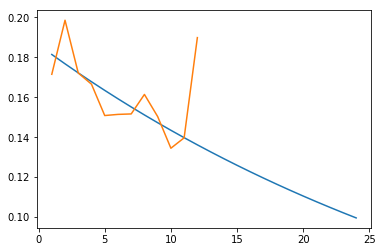

In [49]:
def plot_stat(trend, actual, stat):
    plt.plot(trend['transaction_month'], trend[stat])
    plt.plot(actual['transaction_month'], actual[stat])

trend = zillow_data.preprocessed.error_trend().groupby('transaction_month').mean().reset_index()
actual = zillow_data.preprocessed.error_month
plot_stat(trend, actual, 'logerror_month_std')

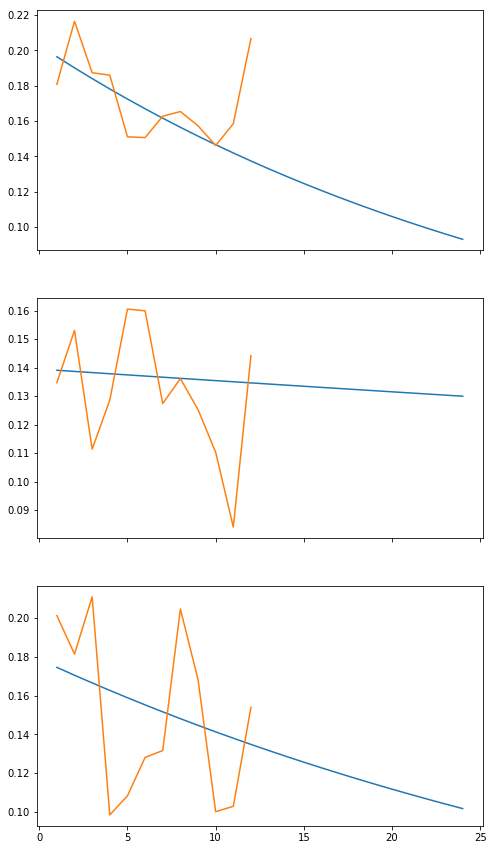

In [61]:
def plot_stat(trend, actual, stat, ax):
    ax.plot(trend['transaction_month'], trend[stat])
    ax.plot(actual['transaction_month'], actual[stat])

actual = zillow_data.preprocessed.error_fips_month
trend = zillow_data.preprocessed.error_trend()
ff, axes = plt.subplots(len(actual['fips'].unique()), sharex=True, figsize=(8,15))
for f, ax in zip(actual['fips'].unique(), axes):
    actual_fips = actual[actual['fips'] == f]
    trend_fips = trend[trend['fips'] == f]
    plot_stat(trend_fips, actual_fips, 'logerror_fips_month_std', ax)

0.17180730467250735

0.14327251133993027

0.13989326523193055

0.15865108328460498

0.13352731483737715

0.10840354639014932

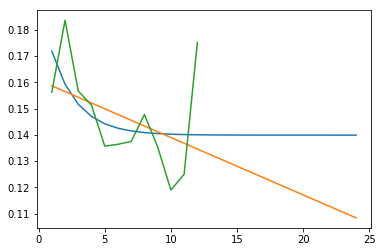

In [85]:
def plot(coefs):
    xs = range(1, 25)
    ys = [ coefs[0]*np.exp(-l*x)+coefs[1] for x in xs ]
    plt.plot(xs, ys)
    display(max(ys), np.mean(ys), min(ys))

def plot_linear(coefs):
    xs = range(1, 25)
    ys = [ coefs[0]*x+coefs[1] for x in xs ]
    plt.plot(xs, ys)
    display(max(ys), np.mean(ys), min(ys))
    
col = 'logerror_abs'
l = 0.5
coefs = np.polyfit(np.exp(-l*logerror_month['transaction_month']), logerror_month[col], 1)
plot(coefs)
coefs = np.polyfit(logerror_month['transaction_month'], logerror_month[col], 1)
plot_linear(coefs)
plt.plot(logerror_month['transaction_month'], logerror_month[col])

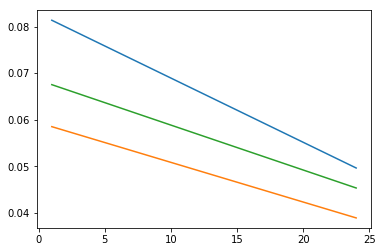

In [27]:
dl.logerror_fips_month
for f in dl.logerror_fips_month['fips'].unique():
    df = dl.logerror_fips_month[dl.logerror_fips_month['fips'] == f]
    plt.plot(df['transaction_month'], df['logerror_abs_fips_month_ave'])

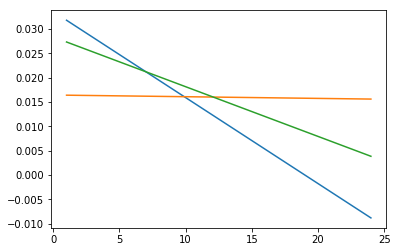

In [28]:
dl.logerror_fips_month
for f in dl.logerror_fips_month['fips'].unique():
    df = dl.logerror_fips_month[dl.logerror_fips_month['fips'] == f]
    plt.plot(df['transaction_month'], df['logerror_abs_fips_month_std'])

In [134]:
from zillow import *

In [10]:
zillow_data = DataLoader()
gc.collect()

349

In [92]:
def clr(epoch, lr_min=0.0001, lr_max=0.001, cycle=10):
    f = abs((epoch % cycle) - (cycle/2)) * 2 / cycle
    lr = lr_max - (lr_max - lr_min) * (1 - f)
    return lr

# for i in range(100):
#     print (clr(i))

clrs = keras.callbacks.LearningRateScheduler(clr)
mc = keras.callbacks.ModelCheckpoint('zillow/best_checkpoint.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
es = keras.callbacks.EarlyStopping(patience=20)
rlr = keras.callbacks.ReduceLROnPlateau(patience=1)

dropcols = set([
    'propertyzoningdesc', 
#    'propertycountylandusecode', 
    'censustractandblock', 
    'rawcensustractandblock',
#    'fips',
    'tractandblock',
    'roomcnt', 
    'bedroomcnt', 
    'taxdelinquencyflag',
    'taxdelinquencyyear',
])

nn = NeuralNet(zillow_data.preprocessed, dropcols=dropcols)
gc.collect()

334

In [93]:
nn.train(epochs=100, callbacks=[clrs, mc, es], verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
architecturalstyletypeid_inp (In (None, 1)             0                                            
____________________________________________________________________________________________________
regionidcity_inp (InputLayer)    (None, 1)             0                                            
____________________________________________________________________________________________________
heatingorsystemtypeid_inp (Input (None, 1)             0                                            
____________________________________________________________________________________________________
propertycountylandusecode_inp (I (None, 1)             0                                            
___________________________________________________________________________________________

Train on 72158 samples, validate on 18117 samples
Epoch 1/100
 3584/72158 [>.............................] - ETA: 56s - loss: 0.1974

KeyboardInterrupt: 

In [80]:
nn.get_model().save_weights('zillow/0.065878423055811319.wgt')

In [94]:
nn.model = keras.models.load_model('zillow/best_checkpoint.wgt')
nn.test()

OSError: Unable to open file (Unable to open file: name = 'zillow/best_checkpoint.wgt', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [95]:
nn.model = keras.models.load_model('zillow/0.06564.model')
nn.model.summary()
nn.test()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
architecturalstyletypeid_inp (In (None, 1)             0                                            
____________________________________________________________________________________________________
regionidcity_inp (InputLayer)    (None, 1)             0                                            
____________________________________________________________________________________________________
heatingorsystemtypeid_inp (Input (None, 1)             0                                            
____________________________________________________________________________________________________
propertycountylandusecode_inp (I (None, 1)             0                                            
___________________________________________________________________________________________

0.065641815279478044

In [96]:
nn.predict()

Predicting... 201610
2985217/2985217 [==============================] - 1748s  


,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,-0.001329,-0.000543,0.000269,0.008086,0.008881,0.009745
1,10759547,-0.001574,-0.000820,-0.000006,0.008022,0.008818,0.009724
2,10843547,0.134220,0.133590,0.132912,0.125679,0.125206,0.124847
3,10859147,0.018415,0.018959,0.019369,0.023672,0.024511,0.025387
4,10879947,-0.051201,-0.050091,-0.048864,-0.034099,-0.032662,-0.031290
5,10898347,0.007533,0.008366,0.009145,0.017660,0.018737,0.019805
6,10933547,-0.001705,-0.000885,0.000024,0.009310,0.010286,0.011317
7,10940747,0.012630,0.013250,0.013843,0.020965,0.022000,0.022968
8,10954547,-0.002739,-0.002030,-0.001167,0.008384,0.009353,0.010333
9,10976347,0.012277,0.012595,0.012783,0.017663,0.018473,0.019373


# EDA

## Training, Properties and Submission Data

In [ ]:
dv = describe_values(dl.get_properties())

In [ ]:
dv[dv['missing %'] < 50]

In [ ]:
tx = 'transactiondate'
train = dl.get_training()
train = split_date(train, tx).drop(tx, axis=1)
train = train.pivot_table(columns='parcelid', index=['transactiondate_year', 'transactiondate_month'], values='logerror')
display(train)

In [ ]:
# how much data is missing?
display(train.isnull().sum().sum() / (train.shape[0]*train.shape[1]))

Most parcels have only 1 data point. Too much missing data to be useful on a per parcel basis.

In [ ]:
prop_parcels = set(dl.get_properties()['parcelid'])
subm_parcels = set(dl.get_submission()['ParcelId'])
trxn_parcels = set(dl.get_training()['parcelid'])
prp = dl.get_properties()
nodt_parcels = set(prp.loc[prp.rawcensustractandblock.isnull(), 'parcelid'])

# Are all properties required in the submission?
display(len(prop_parcels - subm_parcels) == 0)

# Do all properties have recorded transactions?
display(len(prop_parcels - trxn_parcels) == 0)

# How much of the submission is missing?
display(len(subm_parcels - trxn_parcels))

print(len(nodt_parcels & trxn_parcels), 'parcels have no data but have transactions')

Also some parcels have no property data!

## Logerror

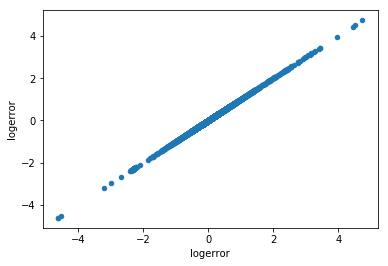

In [8]:
# check for outliers
pd.DataFrame(dl.get_training_preprocessed()['logerror']).plot.scatter(x='logerror', y='logerror')

In [ ]:
summarize(pd.DataFrame(dl.get_training()['logerror']))

In [13]:
# see if logerror varies per month

txm = 'transaction_month'
df = dl.get_training_preprocessed()

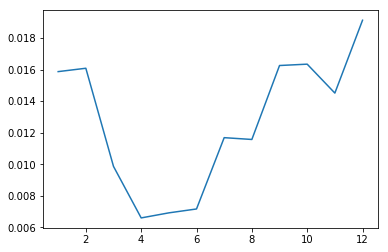

In [14]:
monthly = df[[txm, 'logerror']].groupby([txm])['logerror'].mean()
plt.plot(monthly.index, monthly)

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
plt.ylim(0.06, 0.08)
plt.plot(monthly.index, monthly)

In [ ]:
def plot_monthly(df, grp, val):
    monthly = df.groupby([grp, txm])[val].mean()
    figs = len(monthly.index.levels[0])
    f, axes = plt.subplots(figs, 1, figsize=(8, figs*4), sharex=True, sharey=True)
    for g, ax in zip(monthly.index.levels[0], axes):
        plt.subplot(ax)
        plt.plot(monthly[g].index, monthly[g])

In [ ]:
plot_monthly(df, 'fips', 'logerror')

In [ ]:
plot_monthly(df, 'fips', 'abs_logerror')

In [ ]:
plot_monthly(df, 'regionidcounty', 'abs_logerror')

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
monthly = monthly.reset_index()

In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = .5)
reg.fit(monthly.drop('abs_logerror', axis=1), monthly['abs_logerror'])
preds = pd.DataFrame([ i for i in range(24)])
preds['abs_logerror'] = reg.predict(preds)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['abs_logerror'])
plt.plot(preds.index, preds['abs_logerror'])

In [ ]:
sns.lmplot(x=txm, y="abs_logerror", data=monthly, ci=None, palette="muted")

In [ ]:
from sklearn import linear_model
lm = linear_model.Ridge(alpha = .5)

def regress(df, val):
    monthly = df.groupby(['fips', 'age'])[val].mean()
    preds = pd.DataFrame()
    for f in monthly.index.levels[0]:
        fip = monthly[f].reset_index()
        lm.fit(fip.drop(val, axis=1), fip[val])
        next_months = pd.DataFrame([ i for i in range(13, 25)], columns=['age'])
        next_months[val] = lm.predict(next_months)
        next_months['fips'] = f
#         display(next_months)
        preds = preds.append(next_months)
    preds = preds.append(monthly.reset_index())
    display(preds)

regress(df, 'abs_logerror')